In this example, we will compare stop loss orders and trailing stop orders for different stop values.

In [1]:
import vectorbt as vbt

In [2]:
import numpy as np
import itertools
import yfinance as yf

In [3]:
# Define your params here
INVESTMENT = 1 # in $
FEES = 0.0025 # in %
STOPS = np.arange(0, 0.3, 0.0001)
ASSET_NAME = 'MSFT'

In [4]:
# Download data
ticker = yf.Ticker(ASSET_NAME)
history = ticker.history(period="max")

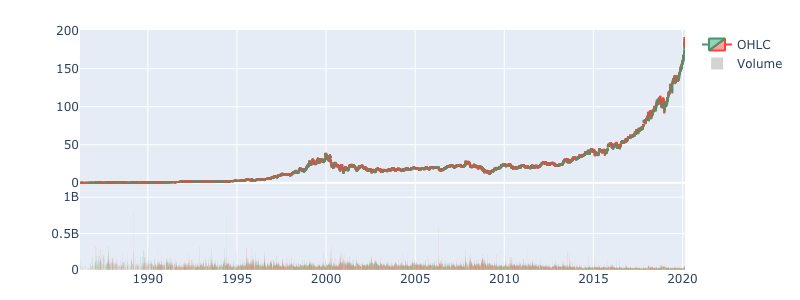

In [5]:
ohlcv = vbt.OHLCV.from_df(history)

ohlcv.plot(index=history.index).show_png()

In [6]:
# Define your basic strategy here (must be of shape (n, 1))
FAST_WINDOW = 30
SLOW_WINDOW = 80

dmac = vbt.DMAC(ohlcv.open, FAST_WINDOW, SLOW_WINDOW)
dmac_entries, dmac_exits = dmac.crossover_signals()

print(dmac_entries.shape, dmac_exits.shape)

(8556, 1) (8556, 1)


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/strategy.py:57: RuntimeWarning:

invalid value encountered in greater

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/strategy.py:60: RuntimeWarning:

invalid value encountered in less



## StopLoss

In [7]:
# Calculate stop loss exits for each stop in STOPS
stoploss = vbt.StopLoss(ohlcv.open, dmac_entries, STOPS)

print(stoploss.exits.shape)

(8556, 3000)


In [8]:
# Combine DMAC exits and StopLoss exits
stoploss_exits = dmac_exits | stoploss.exits

print(stoploss_exits.shape)

(8556, 3000)


In [9]:
stoploss_positions = vbt.Positions.from_signals(dmac_entries, stoploss_exits)
stoploss_portfolio = vbt.Portfolio(ohlcv.open, stoploss_positions, investment=INVESTMENT, fees=FEES)

stoploss_portfolio.key_metrics_df.mean(axis=1)

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio.py:128: RuntimeWarning:

invalid value encountered in less_equal

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio.py:134: RuntimeWarning:

invalid value encountered in greater_equal

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio.py:176: RuntimeWarning:

invalid value encountered in greater

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio.py:180: RuntimeWarning:

invalid value encountered in less



num_trades          57.000000
total_net_profit    70.890702
avg_win              4.635015
avg_loss             1.282985
win_prob             0.424538
loss_prob            0.575462
appt                 1.281594
mdd                  0.668988
dtype: float64

## TrailingStop

In [10]:
# Calculate trailing stop exits for each stop in STOPS
trailstop = vbt.TrailingStop(ohlcv.open, dmac_entries, STOPS)

print(trailstop.exits.shape)

(8556, 3000)


In [11]:
# Combine DMAC exits and TrailingStop exits
tstop_exits = dmac_exits | trailstop.exits

print(tstop_exits.shape)

(8556, 3000)


In [12]:
tstop_positions = vbt.Positions.from_signals(dmac_entries, tstop_exits)
tstop_portfolio = vbt.Portfolio(ohlcv.open, tstop_positions, investment=INVESTMENT, fees=FEES)

tstop_portfolio.key_metrics_df.mean(axis=1)

num_trades          57.000000
total_net_profit    53.170470
avg_win              3.367630
avg_loss             1.084229
win_prob             0.448708
loss_prob            0.551292
appt                 0.962341
mdd                  0.614127
dtype: float64

## Evaluation

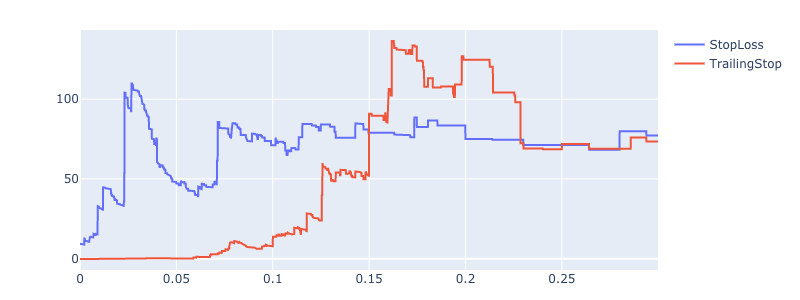

In [13]:
vbt.Scatter(data_labels=['StopLoss', 'TrailingStop'], x_labels=STOPS, data=np.vstack((
    stoploss_portfolio.total_net_profit,
    tstop_portfolio.total_net_profit
))).show_png()

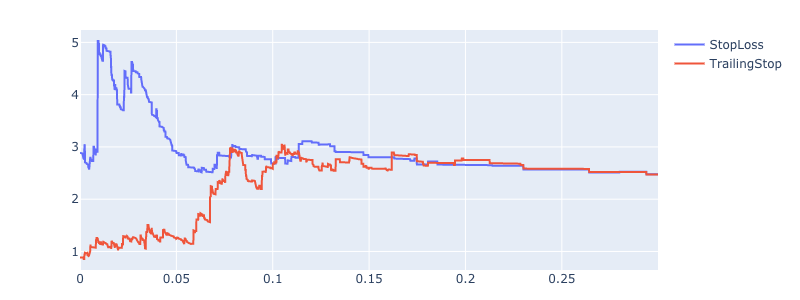

In [14]:
vbt.Scatter(data_labels=['StopLoss', 'TrailingStop'], x_labels=STOPS, data=np.vstack((
    stoploss_portfolio.profit_factor,
    tstop_portfolio.profit_factor
))).show_png()